# Анализ и план по удержанию клиентов сети фитнес-центров «Культурист-датасаентист»

**Цель:** снизить отток клиентов фитнес-центров

**Задачи:**
1. спрогнозировать вероятность оттока;
2. сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3. проанализировать основные признаки, наиболее сильно влияющие на отток;
4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

## Оглавление

1. [Загрузка и просмотр данных](#1id)
2. [Исследовательский анализ данных](#2id)
3. [Модель прогнозирования оттока клиентов](#3id)
4. [Кластеризация клиентов](#4id)
5. [Выводы и рекомендации по работе с клиентами](#5id)

## 1. Загрузка и просмотр данных <a id="1id"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
try:
    gym_churn = pd.read_csv('/home/olga/Downloads/gym_churn.csv')
except:
    gym_churn = pd.read_csv('/datasets/gym_churn.csv')
    
gym_churn.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


**Описание данных**

- `Churn` — факт оттока в текущем месяце;

**Данные пользователя за предыдущий до проверки факта оттока месяц:**
- `gender` — пол
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- `Phone` — наличие контактного телефона
- `Age` — возраст
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента**
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
- `Group_visits` — факт посещения групповых занятий
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

Поменяем буквы в названиях колонок на строчные:

In [3]:
gym_churn.columns = gym_churn.columns.str.lower()

Округлим значения вещественных чисел. Срок до окончания действия абонемента (месяцы) переведем в целочисленные значения:

In [4]:
# округление до двух знаков

gym_churn[['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']] = gym_churn[['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']].round(2)

In [5]:
# изменение типа на целочисленные

gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype(int)

In [6]:
gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0


## 2. Исследовательский анализ данных <a id="2id"></a>

In [7]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Датафрейм достаточно большой: 4000 наблюдений, 14 полей (13 признаков и целевая переменная). Пропусков нет.
Целевая переменная, Сhurn (факт оттока), бинарная величина, что говорит нам о том, что мы решаем задачу бинарной классификации. Для ее решения целесообразно обратиться к логистической регрессии или дереву решений. 
Все признаки являются численными. 

In [8]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943730,4.322750,3.724750,1.879035,1.76707,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355654,4.191297,3.749267,0.972305,1.05290,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.150000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.865000,1.000000,1.000000,1.180000,0.96000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220000,1.000000,3.000000,1.830000,1.72000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.947500,6.000000,5.000000,2.540000,2.51000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590000,12.000000,31.000000,6.020000,6.15000,1.000000


Стандартное отклонение у признаков сильно разница, что говорит о необходимости стандартизации перед обучением моделей. Перед обучением необходимо изменить масштаб распределения, чтобы среднее значение было в нуле, а стандартное отклонение равнялось 1. Таким образом, мы подбираем такие коэффициенты, чтобы оценить вклад каждого признака.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [9]:
churn_value = gym_churn.groupby(by='churn').mean().T
churn_value

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445716,115.082903
month_to_end_contract,5.283089,1.662582


**Характеристики клиентов, которые реже уходят в отток:**
- сотрудники компании-партнёра клуба; 
- клиенты, которые пришли по акции приглашения друга; 
- в среднем берут абонемент более, чем на 5 месяцев;
- время до конца дейсвтия абонемента больше, чем у ушедших;
- вдвое чаще ходят на групповые занятия;
- средний возраст около 29 лет;
- чаще пользуются дополнительными услугами фитнес-центров;
- почти в два раза чаще посещают занятия в неделю

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

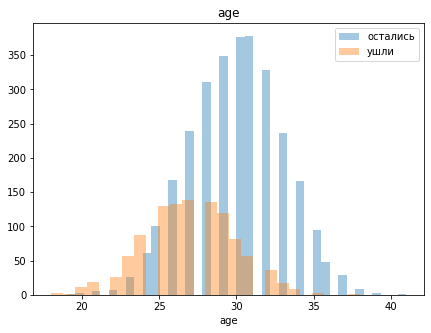

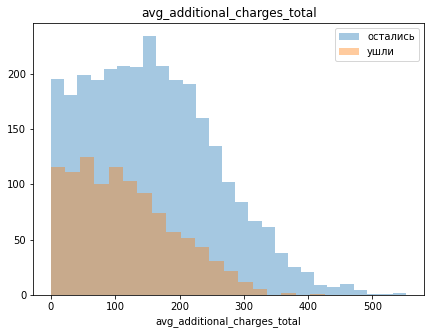

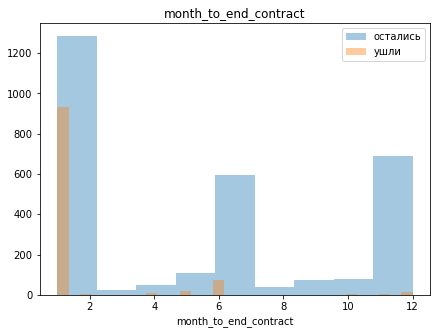

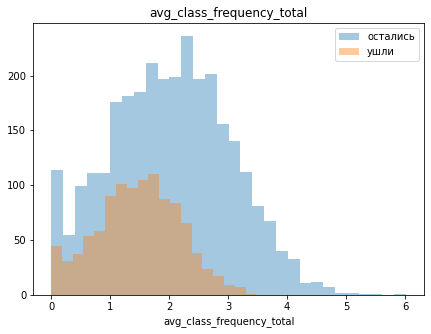

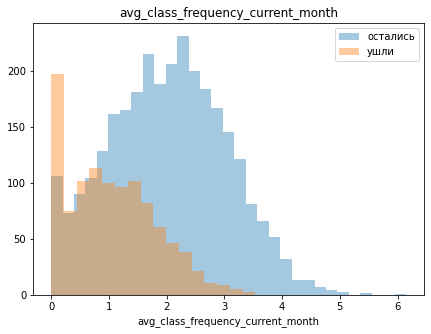

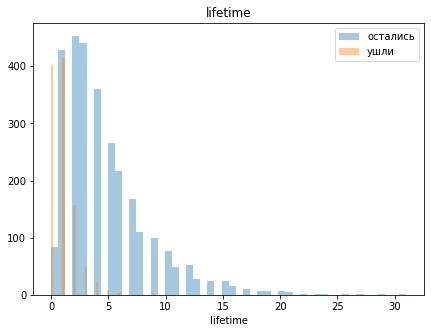

In [10]:
churn_1 = gym_churn.query('churn == 1') # остались
churn_0 = gym_churn.query('churn == 0') # ушли

for column in ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'lifetime']: 
  plt.figure(figsize=(7,5)) 
  plt.title(column)
  sns.distplot(churn_0[column], kde=False)
  sns.distplot(churn_1[column], kde=False)
  plt.legend(['остались', 'ушли'])
  plt.show()

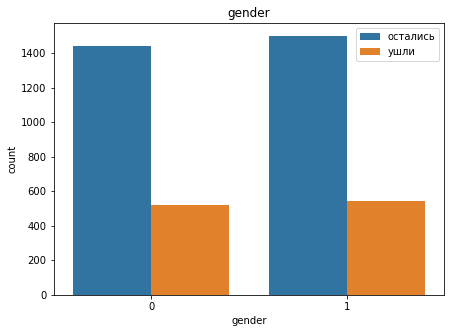

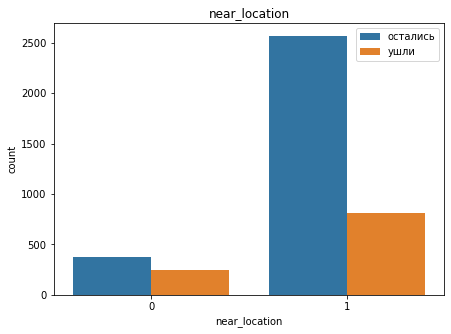

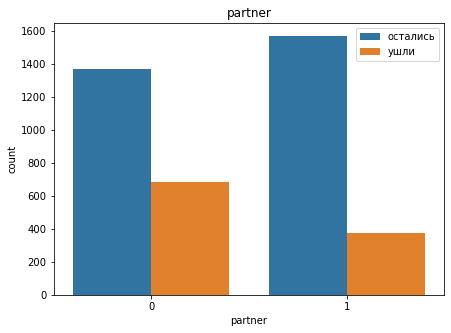

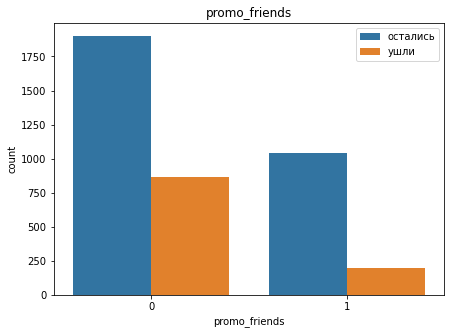

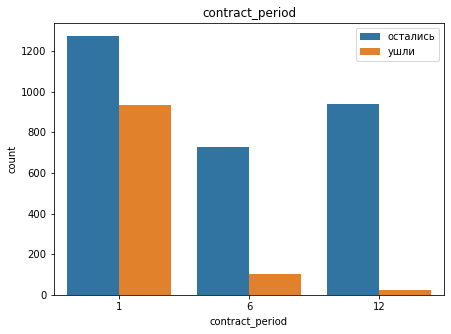

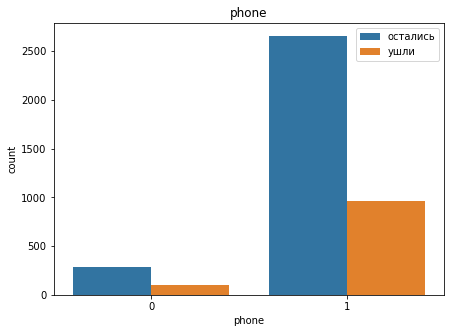

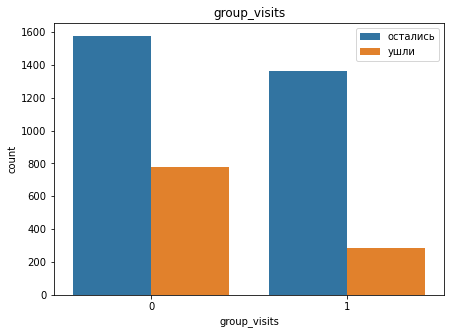

In [11]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period', 'phone', 'group_visits']:
    plt.figure(figsize=(7, 5))
    sns.countplot(x = gym_churn[column], hue='churn', data=gym_churn)
    plt.legend(['остались', 'ушли'])
    plt.title(column)
    plt.show()

Расчитаем матрицу корреляций и построим с помощью heatmap:

In [12]:
cm = gym_churn.corr(method="spearman")

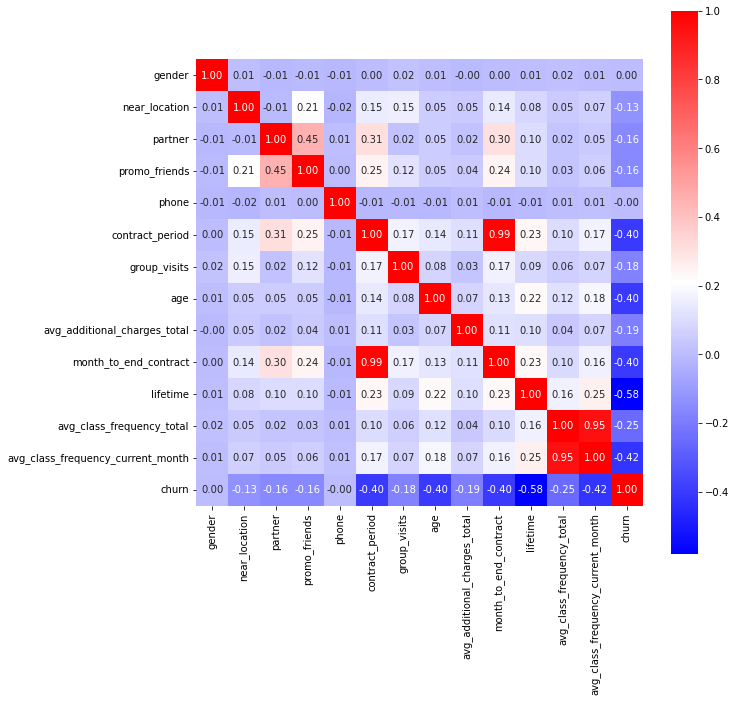

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, square=True, fmt='.2f', cmap="bwr")
plt.show()

Наблюдается мультиколлинеарность: сильная корреляция между сроком до окончания текущего действующего абонемента  и  длительностью текущего действующего абонемента. А также между средней частотой посещений в неделю за предыдущий месяц и средней частотой посещений в неделю за все время с начала действия абонемента. 

Так как мы еще не провели стандартизацию, то пока вручную избавимся от сильно коррелирующих признаков:

In [14]:
gym_churn.drop(['month_to_end_contract','avg_class_frequency_total'], axis = 1, inplace = True)

## 3. Модель прогнозирования оттока клиентов <a id="3id"></a>

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Разделим  данные на признаки (матрица X) и целевую переменную (y) в соотношении 80:20:

In [15]:
X = gym_churn.drop(['churn'], axis=1)
y = gym_churn['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=None)

In [16]:
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler() 

# обучаем нормализатор и преобразуем набор данных (матрица признаков)
x_sc = scaler.fit_transform(X) 

Обучим модель на train-выборке двумя способами: 
- логистической регрессией,
- случайным лесом.

In [17]:
# логистическая регрессия

model_lg = LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced') 
model_lg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=0, solver='liblinear')

In [18]:
# случайный лес

model_rf = RandomForestClassifier(random_state=0)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Оценим обе модели, расчитав следующие метрики:
- `accuracy_score` - доля правильных ответов;
- `precision_score` - точность;
- `recall_score` - полнота

**Метрики для логистической регресии**

In [19]:
# воспользуемся обученной моделью, чтобы сделать прогнозы
probabilities = model_lg.predict_proba(X_test)[:, 1]

# бинарный прогноз
predictions = model_lg.predict(X_test)

# вывод метрик для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Accuracy: 0.88
Precision: 0.69
Recall: 0.93


**Метрики для случайного леса**

In [20]:
# воспользуемся обученной моделью, чтобы сделать прогнозы
probabilities = model_rf.predict_proba(X_test)[:, 1]

# бинарный прогноз
predictions = model_rf.predict(X_test)

# вывод метрик для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Accuracy: 0.89
Precision: 0.80
Recall: 0.75


Метрики логистической регрессии оказались немного лучше, чем метрики случайного леса.

**Оценка важности признаков для линейной регрессии с помощью .coef_**

In [21]:
lg_features = pd.DataFrame({'feature':X_train.columns, 'importance':model_lg.coef_[0]}).sort_values(by='importance', ascending=False)
lg_features['importance'] = [abs(i) for i in lg_features['importance']]
lg_features.sort_values(by='importance', ascending=False)

,feature,importance
10,avg_class_frequency_current_month,1.120681
9,lifetime,0.931999
6,group_visits,0.689750
3,promo_friends,0.500448
5,contract_period,0.264272
4,phone,0.210897
7,age,0.186720
0,gender,0.180850
1,near_location,0.038213
2,partner,0.034421


**Оценка важности признаков для дерева решений с помощью .feature_importances_**

In [22]:
rf_features = pd.DataFrame({'feature': X_train.columns, 'importance': model_rf.feature_importances_}).sort_values(by='importance', ascending=False)
rf_features = rf_features.reset_index()
rf_features

,index,feature,importance
0,9,lifetime,0.324618
1,10,avg_class_frequency_current_month,0.213950
2,7,age,0.136816
3,8,avg_additional_charges_total,0.126139
4,5,contract_period,0.108501
5,6,group_visits,0.021082
6,0,gender,0.016428
7,2,partner,0.016193
8,3,promo_friends,0.015934
9,1,near_location,0.012300


## 4. Кластеризация клиентов <a id="4id"></a>

Разделить клиентов на определенные сегменты поможет кластеризация. Стандартизацию провели раннее.

Сохраним в переменной linked таблицу «связок» между объектами и визуализировать ее, как дендрограмму: 

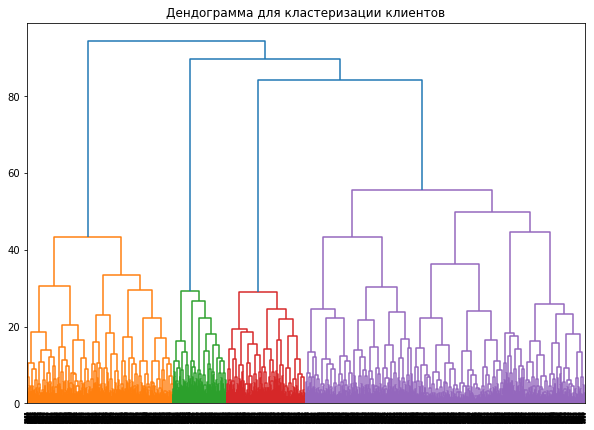

In [23]:
linked = linkage(x_sc, method = 'ward') 

plt.figure(figsize=(10, 7))  
dendrogram(linked, orientation='top')
plt.title('Дендограмма для кластеризации клиентов')
plt.show() 

По полученному графику можем предположить, что целесообразно разбить клиентов на 4 кластера. Задание предлагает разбить на 5.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [24]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state = 0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster'] = labels

Посмотрим на средние значения признаков для кластеров:

In [25]:
gym_churn.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.496447,0.500000,0.500469,0.534791,0.523316
near_location,0.995939,0.000000,1.000000,0.996024,0.862694
partner,0.892386,0.489247,0.216901,0.379722,0.471503
promo_friends,1.000000,0.078853,0.072300,0.009940,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,6.922843,2.994624,2.014085,6.208748,4.777202
group_visits,0.524873,0.232975,0.276995,0.538767,0.427461
age,29.606091,28.679211,27.585915,30.699801,29.297927
avg_additional_charges_total,153.424802,137.125556,119.234892,176.427336,144.208212
lifetime,4.283249,2.974910,1.922066,5.419483,3.940415


Больше всего склонен к оттоку кластеры 0 и 4. Клиенты нечасто ходят на групповые занятия, в среднем они младше 29 лет, меньше используют дополнительные услуги фитнес-центров, у них меньше, чем у остальных остается времени до конца действия абонемента. Средняя частота посещения в неделю у них также ниже, чем у других кластеров.
Более надежными кластерами можно считать 1 и 3: клиенты оставляют деньги за дополнительные услуги больше других. Выше показатель и посещаемости в неделю.

Построим распределения признаков для кластеров:

In [26]:
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'lifetime',
       'avg_class_frequency_current_month', 'churn', 'cluster'],
      dtype='object')

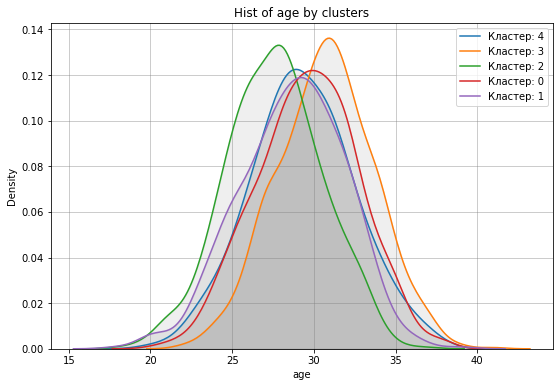

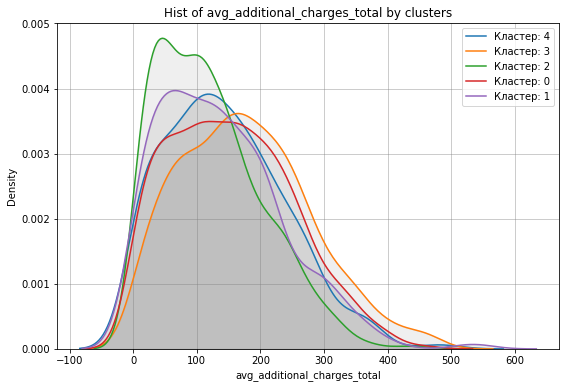

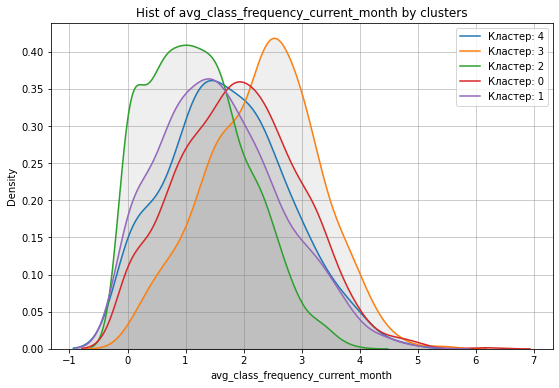

In [27]:
for col in ['age', 'avg_additional_charges_total',  'avg_class_frequency_current_month']:
    fig, ax = plt.subplots(figsize=(9, 6))
    for cl in gym_churn['cluster'].unique():
        # кривая
        sns.kdeplot(gym_churn.query("cluster==@cl")[col], ax=ax, label=f"Кластер: {cl}")
        #  заполнение
        x = ax.lines[-1].get_xdata()
        y = ax.lines[-1].get_ydata()
        ax.fill_between(x, 0, y, color='grey', alpha=0.125)
    ax.legend()
    ax.set_title(f'Hist of {col} by clusters')
    ax.grid(color='grey', alpha=0.5);
    plt.show()

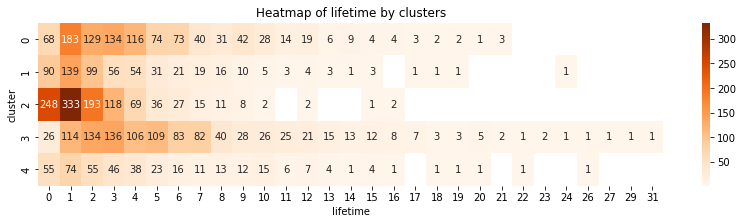

In [28]:
for col in ['lifetime']:
    fig, ax = plt.subplots(figsize=(14, 3))
    viz_data = gym_churn.reset_index()\
                .pivot_table(
                    index='cluster',
                    columns=col,
                    values='index',
                    aggfunc='count'
                    )
    sns.heatmap(viz_data, cmap='Oranges', annot=True, fmt='.0f', ax=ax)
    ax.set_title(f'Heatmap of {col} by clusters')
    ax.grid(False)
    plt.show();

In [29]:
gym_churn[['gender', 'near_location', 'partner', 'promo_friends', 'contract_period', 'phone', 'group_visits']].mean()

gender             0.51025
near_location      0.84525
partner            0.48675
promo_friends      0.30850
contract_period    4.68125
phone              0.90350
group_visits       0.41225
dtype: float64

Для каждого полученного кластера посчитаем долю оттока:

In [30]:
gym_churn.groupby('cluster', as_index=False)['churn'].mean()

,cluster,churn
0,0,0.119797
1,1,0.403226
2,2,0.563380
3,3,0.014911
4,4,0.266839


Кластеры 1 и 2 более остальных склонны к оттоку.

## 5. Выводы и рекомендации по работе с клиентами <a id="5id"></a>

На основе данных о клиентах фитнес-центров «Культурист-датасаентист» был проведен анализ, главной целью которого являлось снизить отток клиентов. В ходе анализа были изучены особенности поведения оставшихся клиентов и тех, кто попал в отток. Эмпирическим путем на основе метрик была выбрана оптимальная модель прогнозирования оттока.

Чтобы понять, какие имеено клиенты склонны "уходить", была проведена кластеризация клиентов, в ходе которой сформировалось 5 групп со схожими признаками. Чаще склонны прекращать пользование услугами фитнес-центров клиенты, которые:
- чуть дальше добирать до фитнес-центра;
- не являются  сотрудник компании-партнёра клуба и не получают скидки на абонементы;
- которые пришли не по рекомендации друзей с их промокодом;
- берут в среднем абонемент менее, чем на два месяца;
- в два раза реже посещают групповые занятия;
- в среднем моложе 27 лет;
- меньше тратят на дополнительные услуги;
- прекращают занятия в среднем меньше, чем через месяц с момента первого посещения;
- вдовое меньше посещают центры в неделю.

**Рекомендации для снижения оттока клиентов:**
- расширить программу лояльности среди компаний-партнеров, чтобы больше людей могли приобретать абонементов по выгодным ценам;
- увеличить рекламу акции «приведи друга» не только среди уже купивших абонемент;
- расширить групповые программы в центрах, которые будут интересны людям младше 30 лет;
- расширить спектр дополнительных услуг (например, ввести экспресс чекапы или предоставлять скидки в магазинах/салонах - партнерах).